In [1]:
from __future__ import annotations

import jax
import jax.numpy as jnp
from jax.random import PRNGKey, multivariate_normal
import pyhf
from typing import Callable, Any, Generator, Iterable
from functools import partial
import matplotlib.pyplot as plt
import neos

jax.config.update("jax_enable_x64", True)
pyhf.set_backend("jax")

# matplotlib settings
plt.rc("figure", figsize=(6, 3), dpi=150, facecolor="w")
plt.rc("legend", fontsize=6)

Array = jnp.ndarray

/Users/phinate/code/relaxed/venv/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


`neos` tackles the problem of learning optimal summary statistics from data. The workflow is explained in more detail [in our paper]() -- this notebook is designed to get you up-and-running with how that workflow looks in code, including how to do this for your own use-case! (if you want to do that for real, please reach out -- we'd love to help you!)

To construct this kind of workflow, you need to specify three things:
- How to construct your summary statistic from data
- How to build your likelihood function from that summary statistic
- A choice of metric relating to how you deem your analysis to be "optimal"

The second bullet in-particular is very important; while we've abstracted away all the technical detail, `neos` is still not a drop-in loss function in the typical sense, since it requires *detailed information from the analyser on how to build the likelihood*. No longer do we have a problem-agnostic notion of "signal" and "background"; instead, we're wanting to optimise our specific problem, so we need to provide specific information. That is how `neos` is "systematic-aware" -- it's a technique that explicitly takes into account how your systematics are modelled. But to do this, we of course need to model them in the first place!

Here, we're going to re-implement the example from the paper with 2-dimensional Gaussian blobs making up our data. We have a nominal estimate for signal and background data, and we also provide "up" and "down" variations that correspond to moving the mean of the background blob. The helper function to generate this dataset is below:

In [2]:
# generate a 20-dimensional toy dataset
n_samples = 5000
n_dim = 2
mu = jnp.zeros(n_dim)
cov = jnp.eye(n_dim)
rng_key = PRNGKey(0)
sig = multivariate_normal(rng_key, mu + 0.5, cov, (n_samples, n_dim))
bkg = multivariate_normal(rng_key, mu - 0.5, cov, (n_samples, n_dim))
bkg_up = multivariate_normal(rng_key,mu - 1, cov, (n_samples, n_dim))
bkg_down = multivariate_normal(rng_key,mu + 1, cov, (n_samples, n_dim))
data = jnp.concatenate([sig, bkg, bkg_up, bkg_down], axis=0)

In [17]:
def generate_data(
    rng: int = 0,
    num_points: int = 10000,
    sig_mean: tuple[float, float] = (-1, 1),
    bup_mean: tuple[float, float] = (2.5, 2),
    bdown_mean: tuple[float, float] = (-2.5, -1.5),
    b_mean: tuple[float, float] = (1, -1),
) -> tuple[Array, Array, Array, Array]:
    sig = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(sig_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )
    bkg_up = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(bup_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )
    bkg_down = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(bdown_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )

    bkg_nom = multivariate_normal(
        PRNGKey(rng),
        jnp.asarray(b_mean),
        jnp.asarray([[1, 0], [0, 1]]),
        shape=(num_points,),
    )
    return sig, bkg_nom, bkg_up, bkg_down

data = generate_data()

Now that we have our data, we need to specify how we construct our summary statistic. We will use a neural network for this, left unspecified until later. Since our likelihood modelling stage will later involve using histograms, we'll also construct a histogram of the output, then scale the yields in each batch for a more "realistic" analysis. This step is wrapped up in a simple convenience function called `neos.hists_from_nn`, which we'll use in a moment.

After this comes the problem-specific part: the likelihood model construction. I mentioned before that we have "up" and "down" datasets -- this is a typical construct in HEP that we use to model the effect of physical parameters. We will then have three histograms for the background data: one for each of the nominal, up, and down samples. The HistFactory prescription for building likelihood functions then models the uncertainty between these by interpolating between their yields. Luckily, this is done under the hood for us in `pyhf` -- we just need to write a dictionary specifying the format of our histograms. This can be found below for our case, where we describe our uncertainty by forming a nuisance parameter `"correlated_bkg_uncertainty"` that modifies the shape of the histogram in a bin-correlated fashion. 

In [18]:
# assume we give a dict of histograms with keys "sig", "bkg_nominal", "bkg_up", "bkg_down".
def model_from_hists(hists: dict[str, Array]) -> pyhf.Model:
    """How to make your HistFactory model from your histograms."""
    spec = {
        "channels": [
            {
                "name": "singlechannel",  # we only have one "channel" (data region)
                "samples": [
                    {
                        "name": "signal",
                        "data": hists["sig"],  # signal
                        "modifiers": [
                            {
                                "name": "mu",
                                "type": "normfactor",
                                "data": None,
                            },  # our signal strength modifier (parameter of interest)
                        ],
                    },
                    {
                        "name": "background",
                        "data": hists["bkg_nominal"],  # background
                        "modifiers": [
                            {
                                "name": "correlated_bkg_uncertainty",
                                "type": "histosys",
                                "data": {
                                    "hi_data": hists["bkg_up"],  # up sample
                                    "lo_data": hists["bkg_down"],  # down sample
                                },
                            },
                        ],
                    },
                ],
            },
        ],
    }
    return pyhf.Model(spec, validate=False)

Now we just have to form our metric of choice from our likelihood model. Here, we have a variety to choose from: uncertainty on the signal strength modifier (cross-section), discovery significance, CLs, even the classic binary cross-entropy (that doesn't use the likelihood at all). Instead of overloading the notebook with losses, I've baked them all into `neos.loss_from_model`, which takes in a `pyhf` model and a string with the metric you want to calculate.

With these ingredients, we just need to compose them in one function, so we can take the gradient of that function with respect to our free parameters:

In [19]:
def pipeline(
    pars: dict[str, Array],
    data: tuple[Array, ...],
    nn: Callable,
    loss: str | Callable,
    bandwidth: float,
    sample_names: Iterable,
    scale_factors: dict[str, float],
    bins: Array | None = None,  # in case you don't want to optimise binning
    lumi: float = 10.0,  # overall scale factor
) -> float:
    data_dct = {k: v for k, v in zip(sample_names, data)}
    if loss.lower() in ["bce", "binary cross-entropy"]:
        return neos.losses.bce(data=data_dct, pars=pars["nn_pars"], nn=nn)
    hists = neos.hists_from_nn(
        pars=pars["nn_pars"],
        nn=nn,
        data=data_dct,
        bandwidth=bandwidth,
        bins=jnp.array([0, *pars["bins"], 1]) if "bins" in pars else bins,
        scale_factors=scale_factors,
        overall_scale=lumi,
    )
    model = model_from_hists(hists)
    return neos.loss_from_model(model, loss=loss)

Below is now mostly training boilerplate! I'll add titles, but should be mostly clear what's going on (ask if not!)

### Initialise network architecture + params

In [20]:
from jax.experimental import stax

rng_state = 0  # random state

# feel free to modify :)
init_random_params, nn = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1),
    stax.Sigmoid,
)

num_features = 2
_, init = init_random_params(PRNGKey(rng_state), (-1, num_features))
init_pars = dict(nn_pars=init)

### Define batching mechanism for data

In [21]:
from sklearn.model_selection import train_test_split
import numpy.random as npr

batch_size = 2000
split = train_test_split(*data, random_state=rng_state)
train, test = split[::2], split[1::2]


def batches(training_data: Array, batch_size: int) -> Generator:
    num_train = training_data[0].shape[0]
    num_complete_batches, leftover = divmod(num_train, batch_size)
    num_batches = num_complete_batches + bool(leftover)

    # batching mechanism
    def data_stream():
        rng = npr.RandomState(rng_state)
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size : (i + 1) * batch_size]
                yield [points[batch_idx] for points in train]

    return data_stream()


batch_iterator = batches(train, batch_size)

### Training loop -- change hyperparameters at will!

In [22]:
from jaxopt import OptaxSolver
import optax
from time import perf_counter

include_bins = True
num_bins = 4
bins = jnp.linspace(0, 1, num_bins+1)  # keep in [0,1] if using sigmoid activation
lr = 1e-3
num_steps = 20
# can choose from "CLs", "discovery", "poi_uncert" [approx. uncert. on mu], "bce" [classifier]
objective = "cls"
keep_metric = "discovery"

# the same keys you used in the model building step [model_from_hists]
data_types = ["sig", "bkg_nominal", "bkg_up", "bkg_down"]
scales = {k: 2.0 if k == "sig" else 10.0 for k in data_types}
loss = partial(
    pipeline,
    nn=nn,
    sample_names=data_types,
    scale_factors=scales,
)

solver = OptaxSolver(loss, opt=optax.adam(lr), jit=True)

pyhf.set_backend("jax", default=True)

if include_bins:
    init_pars["bins"] = bins[
        1:-1
    ]  # don't want to float endpoints [will account for kde spill]
    state = solver.init_state(init_pars)
else:
    if "bins" in init_pars:
        del init_pars["bins"]
    state = solver.init_state(init_pars)

params = init_pars
best_params = init_pars
best_sig = 999
metrics = {k: [] for k in ["cls", "discovery", "poi_uncert"]}

for i in range(num_steps):
    print(f"step {i}: loss={objective}")
    data = next(batch_iterator)
    start = perf_counter()
    params, state = solver.update(
        params, state, bins=bins, data=data, loss=objective, bandwidth=9e-2
    )
    end = perf_counter()
    print(f"update took {end-start:.4g}s")
    if "bins" in params:
        print("bin edges: [0 ", *[f"{f:.3g}" for f in params["bins"]], " 1]")
    for metric in metrics:
        test_metric = loss(params, bins=bins, data=test, loss=metric, bandwidth=1e-8)
        print(f"{metric}={test_metric:.4g}")
        metrics[metric].append(test_metric)
    if metrics["discovery"][-1] < best_sig:
        best_params = params
        best_sig = metrics["discovery"][-1]
    print()

step 0: loss=cls


/Users/phinate/code/relaxed/venv/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


update took 3.336s
bin edges: [0  0.251 0.501 0.749  1]
cls=0.003638
discovery=0.01031
poi_uncert=0.4557

step 1: loss=cls
update took 2.479s
bin edges: [0  0.252 0.5 0.749  1]
cls=7.551e-06
discovery=0.009023
poi_uncert=0.4866

step 2: loss=cls
update took 2.785s
bin edges: [0  0.252 0.5 0.748  1]
cls=1.343e-06
discovery=0.002171
poi_uncert=0.4345

step 3: loss=cls
update took 2.694s
bin edges: [0  0.253 0.499 0.748  1]
cls=9.016e-07
discovery=0.000938
poi_uncert=0.3335

step 4: loss=cls
update took 2.462s
bin edges: [0  0.253 0.499 0.748  1]
cls=1.144e-06
discovery=0.0007609
poi_uncert=0.2733

step 5: loss=cls
update took 2.501s
bin edges: [0  0.254 0.498 0.747  1]
cls=1.444e-06
discovery=0.002308
poi_uncert=0.2688

step 6: loss=cls
update took 2.489s
bin edges: [0  0.254 0.498 0.747  1]
cls=1.663e-06
discovery=0.003885
poi_uncert=0.3062

step 7: loss=cls
update took 3.016s
bin edges: [0  0.254 0.498 0.747  1]
cls=2.248e-06
discovery=0.004728
poi_uncert=0.3386

step 8: loss=cls
updat

## Random visualisations!

### Metrics

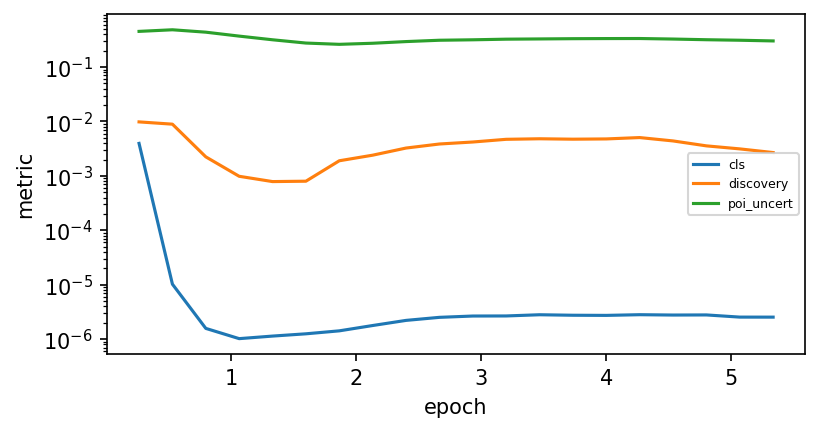

In [41]:
import matplotlib.pyplot as plt

epoch_grid = (jnp.array(list(range(1, num_steps + 1))) * batch_size) / train[0].shape[0]
for k, v in metrics.items():
    if k != "generalised_variance":
        plt.plot(epoch_grid, v, label=k)
plt.yscale("log")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("metric")
plt.savefig("float.png")

### Histograms

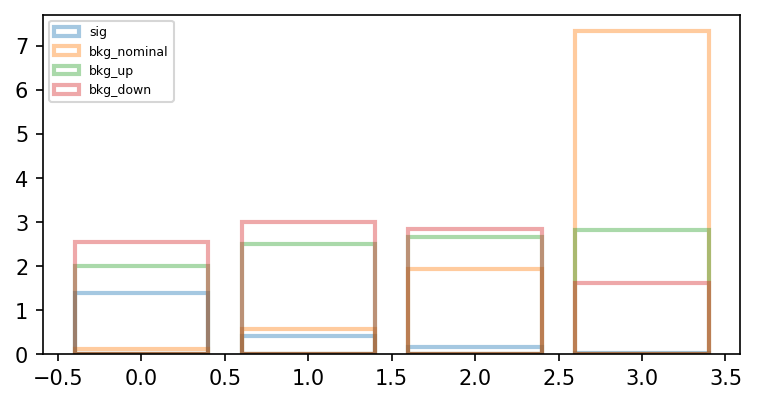

In [42]:
yields = neos.hists_from_nn(
    best_params["nn_pars"],
    {k: v for k, v in zip(data_types, test)},
    nn,
    bandwidth=1e-8,
    scale_factors={k: 2.0 if k == "sig" else 10.0 for k in data_types},
    bins=jnp.array([0, *best_params["bins"], 1]),
)
for c, (l, a) in zip(
    ["C0", "C1", "C2", "C3"], zip(yields, jnp.array(list(yields.values())))
):
    plt.bar(range(len(a)), a, label=l, alpha=0.4, fill=None, edgecolor=c, linewidth=2)
plt.legend()

### Neural network contours (only relevant for the blobs problem)

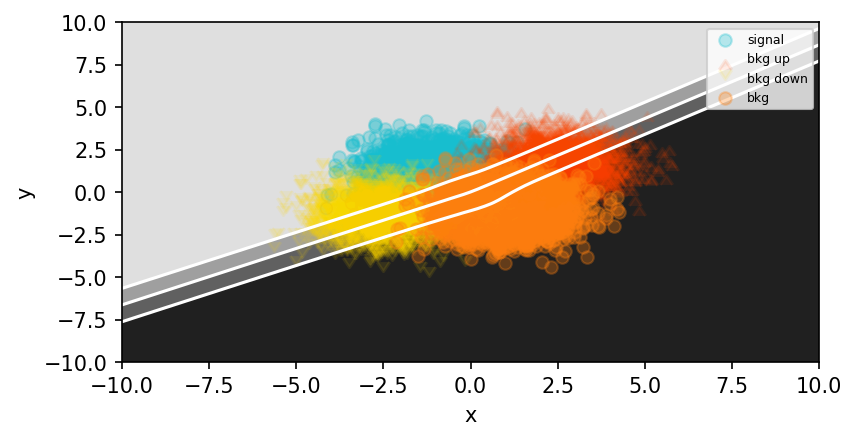

In [43]:
def plot_data_space(
    ax: Any,
    params: dict[str, Any],
    data: Array,
    nn: Callable,
    bins: Array | None = None,
) -> None:
    network = params["nn_pars"]
    bins = params["bins"] if "bins" in params else bins
    g = jnp.mgrid[-10:10:101j, -10:10:101j]
    levels = [0, *bins, 1]
    ax.contourf(
        g[0],
        g[1],
        nn(network, jnp.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
        levels=levels,
        cmap="binary",
    )
    ax.contour(
        g[0],
        g[1],
        nn(network, jnp.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
        colors="w",
        levels=levels,
    )
    sig, bkg_nom, bkg_up, bkg_down = data
    # should definitely not have to repeat this every time lmao
    ax.scatter(sig[:, 0], sig[:, 1], alpha=0.3, c="C9", label="signal")
    ax.scatter(
        bkg_up[:, 0],
        bkg_up[:, 1],
        alpha=0.1,
        c="orangered",
        marker=6,
        label="bkg up",
    )
    ax.scatter(
        bkg_down[:, 0],
        bkg_down[:, 1],
        alpha=0.1,
        c="gold",
        marker=7,
        label="bkg down",
    )
    ax.scatter(bkg_nom[:, 0], bkg_nom[:, 1], alpha=0.3, c="C1", label="bkg")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()


fig, ax = plt.subplots()
plot_data_space(ax, best_params, data=test, nn=nn)

In [39]:
from copy import deepcopy
def make_pipeline():
    # make a dummy model with unit yields
    
    def pipeline(
        pars: dict[str, Array],
        data: tuple[Array, ...],
        nn: Callable,
        loss: str | Callable,
        bandwidth: float,
        sample_names: Iterable,
        scale_factors: dict[str, float],
        bins: Array | None = None,  # in case you don't want to optimise binning
        lumi: float = 10.0,  # overall scale factor,
        skeleton_model: pyhf.Model | None = None
    ) -> float:
        data_dct = {k: v for k, v in zip(sample_names, data)}
        if loss.lower() in ["bce", "binary cross-entropy"]:
            return neos.losses.bce(data=data_dct, pars=pars["nn_pars"], nn=nn)
        hists = neos.hists_from_nn(
            pars=pars["nn_pars"],
            nn=nn,
            data=data_dct,
            bandwidth=bandwidth,
            bins=jnp.array([0, *pars["bins"], 1]) if "bins" in pars else bins,
            scale_factors=scale_factors,
            overall_scale=lumi,
        )
        model = deepcopy(skeleton_model)
        interpcode = model.main_model.modifiers_appliers["histosys"].interpcode
        interp_maker = getattr(pyhf.interpolators, interpcode)

        def update_model(new_nominal, new_histoset):
            model.main_model.nominal_rates = new_nominal
            interpolator = interp_maker(new_histoset)
            model.main_model.modifiers_appliers["histosys"].interpolator = interpolator

        def model_update_from_hists(hists):
            nominal_rates = jnp.stack([hists["bkg_nominal"], hists["sig"]]).reshape(
                model.main_model.nominal_rates.shape
            )
            histoset = [
                [[hists["bkg_down"], hists["bkg_nominal"], hists["bkg_up"]], [hists["sig"]] * 3]
            ]

            return nominal_rates, histoset
        update_model(*model_update_from_hists(hists))
        return neos.loss_from_model(model, loss=loss)

    return pipeline

hacked_pipeline = make_pipeline()

In [40]:
from jaxopt import OptaxSolver
import optax
from time import perf_counter

include_bins = True
num_bins = 4
bins = jnp.linspace(0, 1, num_bins+1)  # keep in [0,1] if using sigmoid activation
lr = 1e-3
num_steps = 20
# can choose from "CLs", "discovery", "poi_uncert" [approx. uncert. on mu], "bce" [classifier]
objective = "cls"
keep_metric = "discovery"

# the same keys you used in the model building step [model_from_hists]
data_types = ["sig", "bkg_nominal", "bkg_up", "bkg_down"]
scales = {k: 2.0 if k == "sig" else 10.0 for k in data_types}
loss = partial(
    hacked_pipeline,
    nn=nn,
    sample_names=data_types,
    scale_factors=scales,
    skeleton_model=model_from_hists({k:v for k,v in zip(data_types, [jnp.ones(num_bins)] * 4)})
)

jax.jit(loss, static_argnames = ("loss"))

solver = OptaxSolver(loss, opt=optax.adam(lr), jit=True)

pyhf.set_backend("jax", default=True)

if include_bins:
    init_pars["bins"] = bins[
        1:-1
    ]  # don't want to float endpoints [will account for kde spill]
    state = solver.init_state(init_pars)
else:
    if "bins" in init_pars:
        del init_pars["bins"]
    state = solver.init_state(init_pars)

params = init_pars
best_params = init_pars
best_sig = 999
metrics = {k: [] for k in ["cls", "discovery", "poi_uncert"]}

for i in range(num_steps):
    print(f"step {i}: loss={objective}")
    data = next(batch_iterator)
    start = perf_counter()
    params, state = solver.update(
        params, state, bins=bins, data=data, loss=objective, bandwidth=9e-2
    )
    end = perf_counter()
    print(f"update took {end-start:.4g}s")
    if "bins" in params:
        print("bin edges: [0 ", *[f"{f:.3g}" for f in params["bins"]], " 1]")
    for metric in metrics:
        test_metric = loss(params, bins=bins, data=test, loss=metric, bandwidth=1e-8)
        print(f"{metric}={test_metric:.4g}")
        metrics[metric].append(test_metric)
    if metrics["discovery"][-1] < best_sig:
        best_params = params
        best_sig = metrics["discovery"][-1]
    print()

step 0: loss=cls


/Users/phinate/code/relaxed/venv/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


update took 3.758s
bin edges: [0  0.251 0.501 0.749  1]
cls=0.003955
discovery=0.009826
poi_uncert=0.4527

step 1: loss=cls
update took 2.474s
bin edges: [0  0.252 0.5 0.748  1]
cls=1.024e-05
discovery=0.008923
poi_uncert=0.4845

step 2: loss=cls
update took 2.314s
bin edges: [0  0.252 0.5 0.748  1]
cls=1.575e-06
discovery=0.002238
poi_uncert=0.4377

step 3: loss=cls
update took 2.422s
bin edges: [0  0.253 0.499 0.747  1]
cls=1.021e-06
discovery=0.0009832
poi_uncert=0.3706

step 4: loss=cls
update took 2.411s
bin edges: [0  0.253 0.499 0.747  1]
cls=1.137e-06
discovery=0.0007857
poi_uncert=0.3173

step 5: loss=cls
update took 2.416s
bin edges: [0  0.254 0.498 0.746  1]
cls=1.252e-06
discovery=0.0007986
poi_uncert=0.2762

step 6: loss=cls
update took 3.636s
bin edges: [0  0.254 0.498 0.746  1]
cls=1.419e-06
discovery=0.001896
poi_uncert=0.2617

step 7: loss=cls
update took 2.483s
bin edges: [0  0.254 0.498 0.745  1]
cls=1.778e-06
discovery=0.002401
poi_uncert=0.2738

step 8: loss=cls
up